In [1]:
import pandas as pd
import numpy as np

import boto3
import pyarrow.parquet as pq

import matplotlib.pyplot as plt
import io
import os

import datetime
from getpass import getpass

import warnings
warnings.filterwarnings('ignore')

In [2]:
AWS_S3_BUCKET = "pipeliner-hb"
AWS_ACCESS_KEY_ID = getpass("AWS_ACCESS_KEY_ID: ")
AWS_SECRET_ACCESS_KEY = getpass("AWS_SECRET_ACCESS_KEY: ")

In [3]:
def pd_read_s3_parquet(key, bucket, s3_client=None, **args):
    if s3_client is None:
        s3_client = boto3.client('s3')
    obj = s3_client.get_object(Bucket=bucket, Key=key)
    return pd.read_parquet(io.BytesIO(obj['Body'].read()), **args)

def pd_read_s3_multiple_parquets(filepath, bucket, s3=None, 
                                 s3_client=None, verbose=False, **args):
    if not filepath.endswith('/'):
        filepath = filepath + '/'  # Add '/' to the end
    if s3_client is None:
        s3_client = boto3.client('s3')
    if s3 is None:
        s3 = boto3.resource('s3')
    s3_keys = [item.key for item in s3.Bucket(bucket).objects.filter(Prefix=filepath)
               if item.key.endswith('.parquet')]
    if not s3_keys:
        print('No parquet found in', bucket, filepath)
    elif verbose:
        print('Load parquets:')
        for p in s3_keys: 
            print(p)
    dfs = [pd_read_s3_parquet(key, bucket=bucket, s3_client=s3_client, **args) 
           for key in s3_keys]
    return pd.concat(dfs, ignore_index=True)

In [4]:
df = pd.DataFrame()
for day in range(1, 21):
    path = f'data/parquet/2022-07-{day:02}'
    print(f"Reading {path} ...")
    temp_df = pd_read_s3_multiple_parquets(path, AWS_S3_BUCKET)
    df = df.append(temp_df)

df

Reading data/parquet/2022-07-01 ...
Reading data/parquet/2022-07-02 ...
Reading data/parquet/2022-07-03 ...
Reading data/parquet/2022-07-04 ...
Reading data/parquet/2022-07-05 ...
Reading data/parquet/2022-07-06 ...
Reading data/parquet/2022-07-07 ...
Reading data/parquet/2022-07-08 ...
Reading data/parquet/2022-07-09 ...
Reading data/parquet/2022-07-10 ...
Reading data/parquet/2022-07-11 ...
Reading data/parquet/2022-07-12 ...
Reading data/parquet/2022-07-13 ...
Reading data/parquet/2022-07-14 ...
Reading data/parquet/2022-07-15 ...
Reading data/parquet/2022-07-16 ...
Reading data/parquet/2022-07-17 ...
Reading data/parquet/2022-07-18 ...
Reading data/parquet/2022-07-19 ...
Reading data/parquet/2022-07-20 ...


,datetime,open,high,low,close,volume
0,2022-07-01 00:00:00,19942.21,19978.47,19804.78,19819.00,467.33201
1,2022-07-01 00:01:00,19818.99,19843.73,19766.22,19838.09,337.35428
2,2022-07-01 00:02:00,19838.08,19859.27,19755.34,19759.96,207.34382
3,2022-07-01 00:03:00,19759.96,19800.13,19747.64,19749.21,244.70052
4,2022-07-01 00:04:00,19749.20,19749.95,19671.54,19720.27,244.00150
...,...,...,...,...,...,...
1435,2022-07-20 23:55:00,23260.50,23260.62,23201.19,23221.87,133.72606
1436,2022-07-20 23:56:00,23223.06,23234.93,23183.10,23212.22,169.02871
1437,2022-07-20 23:57:00,23209.65,23217.04,23180.00,23182.15,101.88660
1438,2022-07-20 23:58:00,23184.72,23241.10,23174.67,23223.52,121.00841


# 종가 예측하는 XGBoost 모델

## Preprocessing

In [5]:
# from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [46]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['datetime', 'close'], axis=1), df['close'], test_size=0.2, random_state=0, shuffle=False)

In [47]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(23040, 4) (23040,)
(5760, 4) (5760,)


In [48]:
x_train

,open,high,low,volume
0,19942.21,19978.47,19804.78,467.33201
1,19818.99,19843.73,19766.22,337.35428
2,19838.08,19859.27,19755.34,207.34382
3,19759.96,19800.13,19747.64,244.70052
4,19749.20,19749.95,19671.54,244.00150
...,...,...,...,...
1435,21199.22,21212.23,21181.00,55.61251
1436,21182.98,21193.73,21176.58,33.68477
1437,21179.06,21187.92,21171.00,34.97860
1438,21185.44,21218.90,21183.76,64.74500


In [49]:
y_train

0       19819.00
1       19838.09
2       19759.96
3       19749.21
4       19720.27
          ...   
1435    21182.98
1436    21179.06
1437    21185.44
1438    21216.79
1439    21195.60
Name: close, Length: 23040, dtype: float64

## Modeling

In [11]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [50]:
model = xgb.XGBRegressor(n_estimators=500)

model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

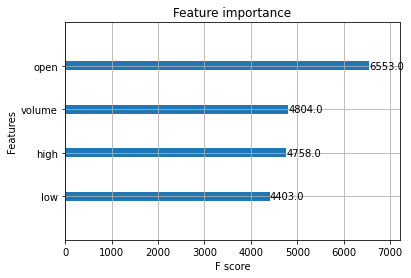

In [51]:
plot_importance(model)
plt.show()

## Predict

In [52]:
pred = model.predict(x_test)

In [53]:
pred.shape[0]

5760

### Visualization

In [32]:
df.reset_index().loc[x_test.index.to_list(), 'datetime']

23040   2022-07-17 00:00:00
23041   2022-07-17 00:01:00
23042   2022-07-17 00:02:00
23043   2022-07-17 00:03:00
23044   2022-07-17 00:04:00
                ...        
28795   2022-07-20 23:55:00
28796   2022-07-20 23:56:00
28797   2022-07-20 23:57:00
28798   2022-07-20 23:58:00
28799   2022-07-20 23:59:00
Name: datetime, Length: 5760, dtype: datetime64[ns]

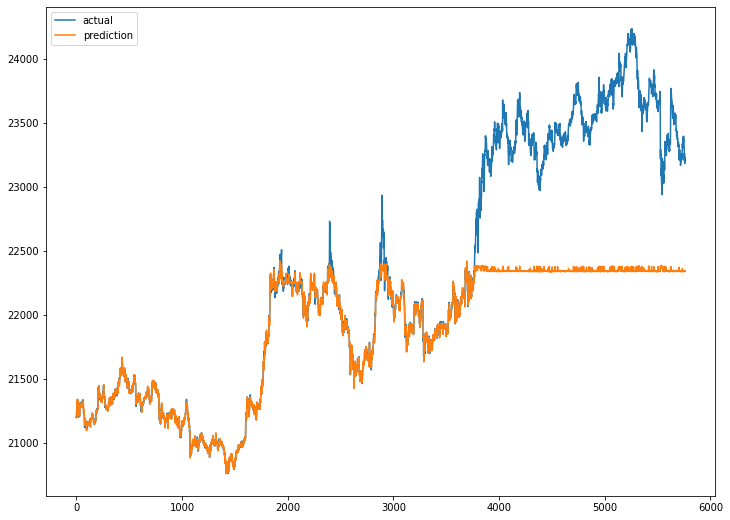

In [54]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test), label='actual')
plt.plot(pred, label='prediction')
plt.legend()
# plt.xticks(ticks=range(pred.shape[0]), labels=df.reset_index().loc[x_test.index.to_list(), 'datetime'], rotation=90)
plt.show()

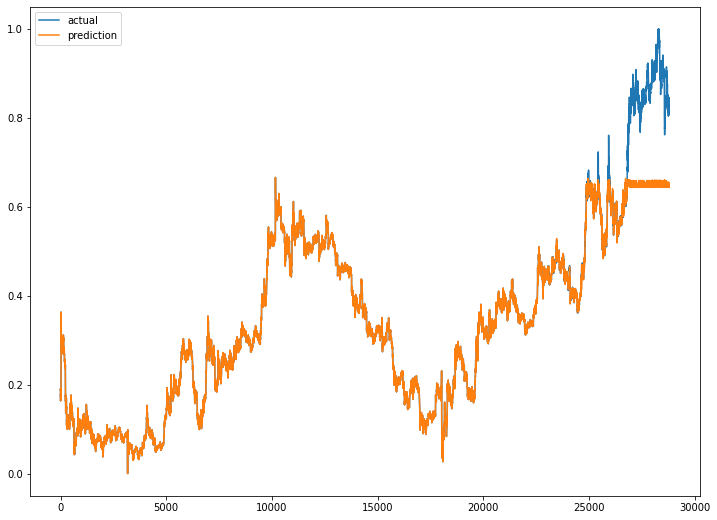

In [41]:
plt.figure(figsize=(12, 9))
plt.plot(np.append(y_train, y_test), label='actual')
plt.plot(np.append(y_train, pred), label='prediction')
plt.legend()
# plt.xticks(ticks=range(pred.shape[0]), labels=df.reset_index().loc[x_test.index.to_list(), 'datetime'], rotation=90)
plt.show()

## Save Model

In [22]:
import pickle

In [55]:
pickle.dump(model, open('/home/ubuntu/knkwon/modeling/models/xgb_test', 'wb'))

## Load Model

In [56]:
x_test

,open,high,low,volume
0,21195.60,21205.46,21187.19,78.80792
1,21198.30,21209.82,21193.42,42.53579
2,21197.04,21207.99,21188.56,48.02886
3,21205.29,21264.99,21193.10,271.90644
4,21252.56,21262.79,21220.17,167.95799
...,...,...,...,...
1435,23260.50,23260.62,23201.19,133.72606
1436,23223.06,23234.93,23183.10,169.02871
1437,23209.65,23217.04,23180.00,101.88660
1438,23184.72,23241.10,23174.67,121.00841


In [45]:
model = pickle.load(open('/home/ubuntu/knkwon/modeling/models/xgb_test', 'rb'))
print(model.predict(np.array([[0.2, 0.4, 0.3, 0.01]])))

[0.34606498]
